In [13]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings("ignore") 

plt.rcParams["font.family"]="Kaiti"
matplotlib.rcParams['axes.unicode_minus'] = False 
plt.style.use('ggplot')
#sns.set_style('darkgrid')
#sns.set(font="Kaiti")

import matplotlib as mpl
from cycler import cycler
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '-'

from tqdm import tqdm
#----------------核心模型----------------
from pmdarima.arima import auto_arima
#----------------忽略报警----------------
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 读取训练数据和测试数据
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submit = pd.read_csv('sample_submit.csv')
# 数据量
# print(train.shape, test.shape)
# 训练集信息，快速了解数据基本情况，包含column（列名）、Non-Null Count（非缺失样本数）、Dt
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107296 entries, 0 to 107295
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   session_id      107296 non-null  int64  
 1   rank            107296 non-null  int64  
 2   u_q             107296 non-null  float64
 3   coolant         107296 non-null  float64
 4   stator_winding  107296 non-null  float64
 5   u_d             107296 non-null  float64
 6   stator_tooth    107296 non-null  float64
 7   motor_speed     107296 non-null  float64
 8   i_d             107296 non-null  float64
 9   i_q             107296 non-null  float64
 10  stator_yoke     107296 non-null  float64
 11  ambient         107296 non-null  float64
 12  torque          107296 non-null  float64
 13  pm              107296 non-null  float64
dtypes: float64(12), int64(2)
memory usage: 11.5 MB


In [3]:
train

,session_id,rank,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,stator_yoke,ambient,torque,pm
0,0,13,89.396964,18.755619,64.267929,-94.043390,49.644433,4999.957225,-140.333256,53.092959,36.357005,21.537047,48.330039,47.584192
1,0,14,88.838611,19.222207,63.970372,-94.502894,49.637457,4999.951532,-140.101997,53.141117,36.271015,21.621879,48.547166,47.383591
2,0,15,89.518317,18.891216,63.708574,-93.920111,49.539251,4999.952468,-140.406027,53.099484,36.224037,21.728331,48.295140,47.146833
3,0,16,89.073602,19.005388,63.449170,-94.518250,49.323337,4999.956231,-139.980127,53.173162,36.100438,21.707387,48.406753,46.897395
4,0,17,89.523293,19.303722,63.276967,-93.966083,49.306077,4999.952391,-140.561051,53.080814,35.966480,22.098269,48.415704,46.661446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107291,294,413,1.209628,33.383425,63.491825,0.937007,56.593806,-0.002081,-2.000242,1.098096,48.028519,23.549694,0.000490,68.339319
107292,294,414,1.373009,33.292696,64.357120,0.805124,57.470843,-0.000615,-2.000626,1.096763,48.792651,23.536386,0.000637,68.415773
107293,294,415,1.253125,33.530957,65.188994,0.945592,57.760254,0.005464,-2.001140,1.099104,49.292459,23.582271,0.000930,68.457560
107294,294,416,1.280524,33.316147,65.655702,0.884900,58.414420,0.181534,-2.000844,1.100347,49.338983,23.576428,0.001775,68.608494


In [4]:
data = train[['session_id','rank','pm']]
data

,session_id,rank,pm
0,0,13,47.584192
1,0,14,47.383591
2,0,15,47.146833
3,0,16,46.897395
4,0,17,46.661446
...,...,...,...
107291,294,413,68.339319
107292,294,414,68.415773
107293,294,415,68.457560
107294,294,416,68.608494


In [5]:
data.groupby('session_id')['rank'].count().describe()

count    295.000000
mean     363.715254
std      100.043529
min       37.000000
25%      405.000000
50%      405.000000
75%      405.000000
max      736.000000
Name: rank, dtype: float64

In [6]:
data[data['session_id'] == 0]

,session_id,rank,pm
0,0,13,47.584192
1,0,14,47.383591
2,0,15,47.146833
3,0,16,46.897395
4,0,17,46.661446
...,...,...,...
64,0,77,24.896908
65,0,78,24.320442
66,0,79,24.462605
67,0,80,24.460167


lgbm

In [7]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_validate,KFold,cross_val_score
from sklearn.model_selection import train_test_split

cv_score=[] 
for i in range(0,294):
    X = data[data['session_id'] == i]['rank'].to_numpy().reshape(-1,1)
    y = data[data['session_id'] == i]['pm'].to_numpy().reshape(-1,1)
    train_x,test_x,train_y,test_y = train_test_split(X,y,test_size=0.9)
    lgb = LGBMRegressor(
        random_state=2022
    )
    lgb = lgb.fit(train_x, train_y)
    lgb_cv=cross_val_score(lgb,X=test_x,y=test_y,cv=5,scoring='neg_mean_absolute_error')
    cv_score.append(lgb_cv.mean())
-pd.DataFrame(cv_score).mean()

0    0.343087
dtype: float64

In [81]:
"""
0.34345
1.26
0.341565
"""

'\n0.34345\n\n\n\n'

In [22]:
for i in range(0,294):
    X = data[data['session_id'] == i]['rank'].to_numpy().reshape(-1,1)
    y = data[data['session_id'] == i]['pm'].to_numpy().reshape(-1,1)
    test_X = test[test['session_id'] == i]['rank'].to_numpy().reshape(-1,1)[::-1]
    lgb = LGBMRegressor(
        random_state=2022
    )
    lgb = lgb.fit(X,y)
    y_pred=lgb.predict(test_X)
    sample_submit.loc[sample_submit['session_id']==i,'pm'] = y_pred

In [23]:
sample_submit.to_csv('result3.csv', index=False)
pd.read_csv('result3.csv')

,session_id,rank,pm
0,0,1,45.000516
1,0,2,45.000516
2,0,3,45.000516
3,0,4,45.000516
4,0,5,45.000516
...,...,...,...
3535,294,8,0.000000
3536,294,9,0.000000
3537,294,10,0.000000
3538,294,11,0.000000


In [35]:

i=3
X = data[data['session_id'] == i]['rank'].to_numpy().reshape(-1,1)
y = data[data['session_id'] == i]['pm'].to_numpy().reshape(-1,1)
train_x,test_x,train_y,test_y = train_test_split(X,y,test_size=0.9)
test_X = test[test['session_id'] == i]['rank'].to_numpy().reshape(-1,1)[::-1]
lgb = LGBMRegressor(
    random_state=2022
)
lgb = lgb.fit(train_x, train_y)
lgb_cv=cross_val_score(lgb,X=test_x,y=test_y,cv=5,scoring='neg_mean_absolute_error').mean()
-lgb_cv

0.044238107565861655

In [50]:
i=29
X = data[data['session_id'] == i]['rank'].to_numpy().reshape(-1,1)
y = data[data['session_id'] == i]['pm'].to_numpy().reshape(-1,1)
test_X = test[test['session_id'] == i]['rank'].to_numpy().reshape(-1,1)[::-1]
lgb = LGBMRegressor(
    random_state=2022
)
lgb = lgb.fit(X,y)
y_pred=lgb.predict([[140,]])
y_pred

array([47.13641165])

可视化

<AxesSubplot:xlabel='rank', ylabel='pm'>

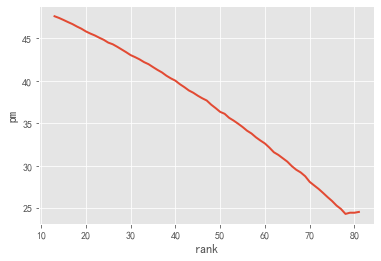

In [14]:
sns.lineplot(data=data[data['session_id']==0],x='rank',y='pm')

<AxesSubplot:xlabel='rank', ylabel='pm'>

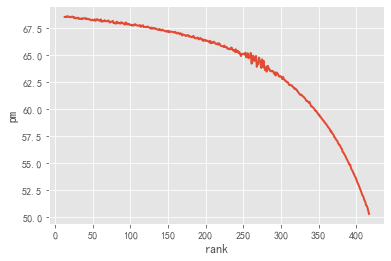

In [15]:
sns.lineplot(data=data[data['session_id']==1],x = 'rank',y='pm')

<AxesSubplot:xlabel='rank', ylabel='pm'>

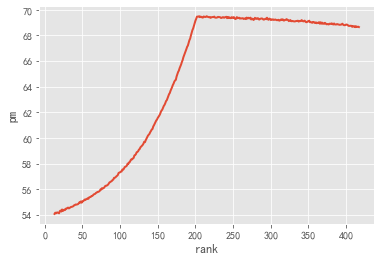

In [16]:
sns.lineplot(data=data[data['session_id']==2],x = 'rank',y='pm')

<AxesSubplot:xlabel='rank', ylabel='pm'>

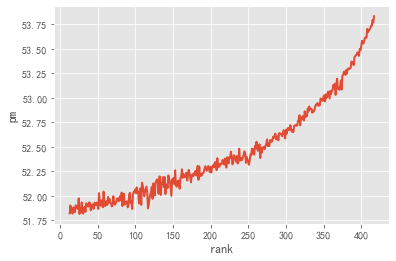

In [17]:
sns.lineplot(data=data[data['session_id']==3],x = 'rank',y='pm')

<AxesSubplot:xlabel='rank', ylabel='pm'>

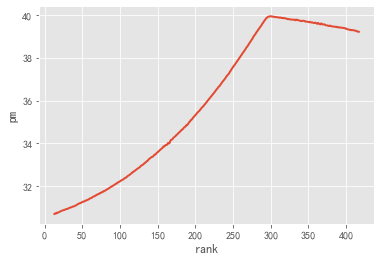

In [18]:
sns.lineplot(data=data[data['session_id']==5],x = 'rank',y='pm')

<AxesSubplot:xlabel='rank', ylabel='pm'>

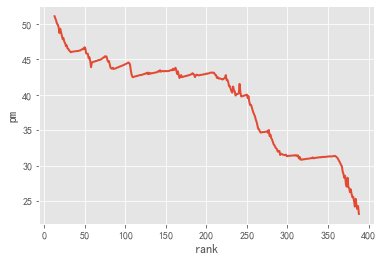

In [19]:
sns.lineplot(data=data[data['session_id']==292],x = 'rank',y='pm')

<AxesSubplot:xlabel='rank', ylabel='pm'>

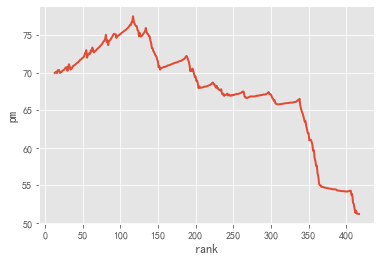

In [20]:
sns.lineplot(data=data[data['session_id']==293],x = 'rank',y='pm')

<AxesSubplot:xlabel='rank', ylabel='pm'>

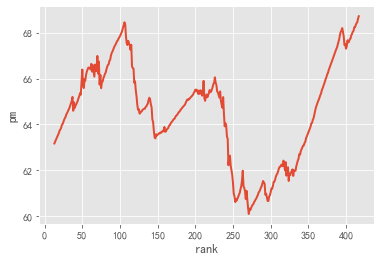

In [21]:
sns.lineplot(data=data[data['session_id']==294],x = 'rank',y='pm')

<AxesSubplot:>

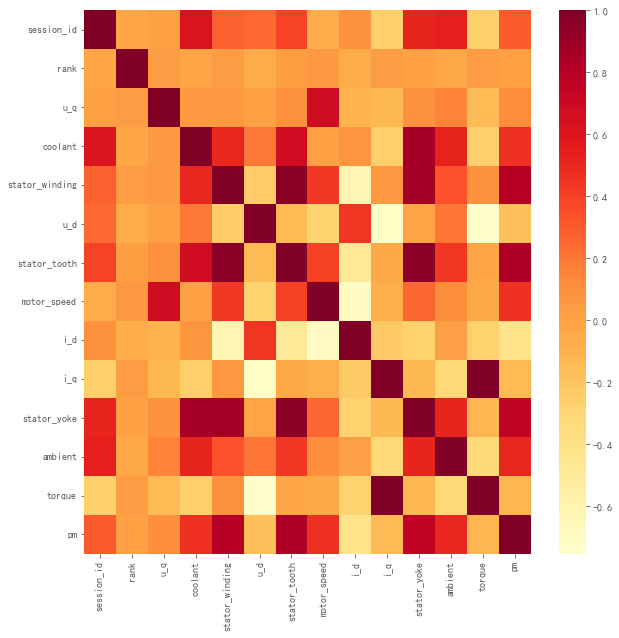

In [23]:
fig = plt.figure(1, figsize = (10,10))
corr = train.corr()
sns.heatmap(corr,cmap="YlOrRd")

auto_arima

In [4]:
# 分测量会话session_id进行预测
for session_id in tqdm(sample_submit['session_id'].unique()):
    # 获取对应session_id的pm，并按rank从大到小排序
    train_y = train[train['session_id']==session_id]['pm'].tolist()[::-1]

    # 训练模型
    model = auto_arima(train_y, start_p=1, start_q=1, max_p=9, max_q=6, max_d=3,
    mseasonal=False, m=1, test='adf', trace=False,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True, information_criterion='bic', njob=-1)
    # 把训练数据放入auto_arima得到最优模型，ARIMA里的三个参数PDQ都是可以进行自动调参的，就
    # 它会自动对这三个参数进行调整，这里m=1的意思是不考虑季节性。
    # 预测未来12个单位的pm
    pred_res = model.predict(12)
    # 保存对于session_id的pm
    sample_submit.loc[sample_submit['session_id']==session_id, 'pm'] = pred_res

sample_submit.to_csv('result.csv', index=False)


100%|██████████| 295/295 [15:11<00:00,  3.09s/it]


In [12]:
#安装相关依赖库 如果是windows系统，cmd命令框中输入pip安装，参考上述环境配置
#!pip install pandas
#---------------------------------------------------
#导入库
#----------------数据探索----------------
import pandas as pd
import numpy as np
#----------------忽略报警----------------
import warnings
warnings.filterwarnings('ignore')

In [13]:
# 读取训练数据和测试数据
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submit = pd.read_csv('sample_submit.csv')

# 数据量
# print(train.shape, test.shape)
# 训练集信息，快速了解数据基本情况，包含column（列名）、Non-Null Count（非缺失样本数）、Dtype（特征类型）等
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107296 entries, 0 to 107295
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   session_id      107296 non-null  int64  
 1   rank            107296 non-null  int64  
 2   u_q             107296 non-null  float64
 3   coolant         107296 non-null  float64
 4   stator_winding  107296 non-null  float64
 5   u_d             107296 non-null  float64
 6   stator_tooth    107296 non-null  float64
 7   motor_speed     107296 non-null  float64
 8   i_d             107296 non-null  float64
 9   i_q             107296 non-null  float64
 10  stator_yoke     107296 non-null  float64
 11  ambient         107296 non-null  float64
 12  torque          107296 non-null  float64
 13  pm              107296 non-null  float64
dtypes: float64(12), int64(2)
memory usage: 11.5 MB


平均增长率

In [14]:
for i in range(0,12):
    rk = 12 - i
    # 平均增长率计算
    ratio = 0
    for j in range(1,25):
        ratio += train[train['rank']==rk+j]['pm'].values / train[train['rank']==rk+j+1]['pm'].values
    ratio /= j
    
    # 当前rank结果 * 平均增长率 = 下个rank的结果
    res = train[train['rank']==rk+1]['pm'].values * ratio
    
    # 将当前计算的rank结果拼接到训练数据，便于计算接下来的rank结果
    train = train.append(pd.DataFrame({'pm':res,'rank':[rk]*test['session_id'].nunique()}))
    
    # 保存对于rank的pm
    sample_submit.loc[sample_submit['rank']==rk, 'pm'] = train.loc[train['rank']==rk, 'pm'].values

In [15]:
sample_submit.to_csv('result1.csv', index=False)